In [1]:
import json
from time import time

import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.cross_validation import cross_val_score, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold
from sklearn.linear_model import PassiveAggressiveClassifier, Perceptron, RidgeClassifier, SGDClassifier, SGDRegressor
from sklearn.metrics import precision_recall_fscore_support
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.utils.extmath import density

/home/antonio/virtualenvs/elbulli/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
>>> measurements = [
...     {'city': 'Dubai', 'temperature': 33.},
...     {'city': 'London', 'temperature': 12.},
...     {'city': 'San Fransisco', 'temperature': 18.},
... ]

>>> from sklearn.feature_extraction import DictVectorizer
>>> vec = DictVectorizer()

>>> vec.fit_transform(measurements).toarray()
# array([[  1.,   0.,   0.,  33.],
#        [  0.,   1.,   0.,  12.],
#        [  0.,   0.,   1.,  18.]])

>>> vec.get_feature_names()
# ['city=Dubai', 'city=London', 'city=San Fransisco', 'temperature']

['city=Dubai', 'city=London', 'city=San Fransisco', 'temperature']

In [6]:
measurements = [
    {'ingrs': ['i1','i2'], 'techs': ['t1']},
    {'ingrs': ['i1','i3'], 'techs': ['t2', 't3']},
    {'ingrs': ['i4','i5','i6'], 'techs': ['t1', 't4']},
]
vec.fit_transform(measurements).toarray()

ValueError: could not convert string to float: 't1'

In [127]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 7)
matplotlib.rcParams.update({'figure.autolayout': True})
font = {'size': 12}
matplotlib.rc('font', **font)

# Data

## Raw ingredients and techniques

### elbulli

In [2]:
elbulli_raw_recipes_df = pd.read_csv('data/recipes_elbulli_raw.csv')

In [3]:
elbulli_raw_recipes_df.dtypes

_id             int64
title          object
year            int64
ingredients    object
techniques     object
dtype: object

In [4]:
elbulli_raw_recipes_df.head()

,_id,title,year,ingredients,techniques
0,1,terrina de melón con gelée de oporto,1987,"[""hojas de gelatina"",""pimienta blanca"",""oporto...","[""agua""]"
1,10,salmonetes Gaudí,1987,"[""vinagre balsámico"",""pimienta negra"",""orégano...","[""en agua"",""puré"",""cocción"",""asar"",""horno"",""as..."
2,100,oursins,1990,"[""avellanas tostadas"",""chocolate"",""claras de h...","[""horno"",""secar"",""al horno""]"
3,1000,ravioli sférico de té con cubo helado de limón,2004,"[""limón"",""agua"",""alginato sódico"",""infusión de...","[""fría"",""agua""]"
4,1001,ceps en ámbar de su caldo,2004,"[""pimienta negra"",""láminas de ceps"",""ceps"",""ca...","[""en agua"",""hervido"",""a fuego lento"",""cocer"",""..."


In [6]:
elbulli_raw_recipes_df['ingredients'] = elbulli_raw_recipes_df.apply(lambda x: json.loads(x['ingredients']), axis=1)
elbulli_raw_recipes_df['techniques'] = elbulli_raw_recipes_df.apply(lambda x: json.loads(x['techniques']), axis=1)

In [7]:
recipes_df.head()

,_id,title,year,ingredients,techniques,creativity
0,1,terrina de melón con gelée de oporto,1987,"[aceite de oliva, agua, gelatina de oporto, ho...",[agua],10
1,10,salmonetes Gaudí,1987,"[aceite de oliva, anchoa en aceite, calabacín,...","[agua, brunoise, cocción, hervir, horno, marca...",10
2,100,oursins,1990,"[avellanas tostadas, azúcar, cacao en polvo, c...","[horno, secar]",10
3,1000,ravioli sférico de té con cubo helado de limón,2004,"[agua, alginato sódico, azúcar, infusión, limó...","[agua, min]",30
4,1001,ceps en ámbar de su caldo,2004,"[aceite de girasol, aceite de oliva, agua, ajo...","[agua, cazuela, confitar, conservar, escaldar,...",30


In [4]:
elbulli_raw_recipes_df['creativity'] = elbulli_raw_recipes_df.apply(
    lambda x: 10 if 1987 <= x['year'] <= 1997 else \
              20 if 1998 <= x['year'] <= 2001 else \
              30 if 2002 <= x['year'] <= 2005 else \
              'UNKOWN', axis=1)

In [5]:
elbulli_raw_recipes_df.head()

,_id,title,year,ingredients,techniques,creativity
0,1,terrina de melón con gelée de oporto,1987,"[""aceite de oliva"",""agua"",""gelatina de oporto""...","[""agua""]",10
1,10,salmonetes Gaudí,1987,"[""aceite de oliva"",""anchoa en aceite"",""calabac...","[""agua"",""brunoise"",""cocción"",""hervir"",""horno"",...",10
2,100,oursins,1990,"[""avellanas tostadas"",""azúcar"",""cacao en polvo...","[""horno"",""secar""]",10
3,1000,ravioli sférico de té con cubo helado de limón,2004,"[""agua"",""alginato sódico"",""azúcar"",""infusión"",...","[""agua"",""min""]",30
4,1001,ceps en ámbar de su caldo,2004,"[""aceite de girasol"",""aceite de oliva"",""agua"",...","[""agua"",""cazuela"",""confitar"",""conservar"",""esca...",30


### cookpad

In [20]:
cookpad_raw_recipes_df = pd.read_csv('data/recipes_cookpad_raw.csv')

In [21]:
cookpad_raw_recipes_df.dtypes

_id             int64
title          object
cuisine        object
year            int64
ingredients    object
techniques     object
dtype: object

In [22]:
cookpad_raw_recipes_df.head()

,_id,title,cuisine,year,ingredients,techniques
0,100002,Boquerones en Vinagre al estilo andaluz,España,2009,"[""ajo"",""perejil"",""limón"",""boquerones"",""vinagre...","[""macerar"",""agua""]"
1,100005,Croquetas marineras,España,2009,"[""oliva"",""harina"",""pimienta"",""huevos"",""huevo"",...","[""agua"",""rebozar"",""en agua""]"
2,100007,Bolitas árabes con ensalada,Marruecos,2009,"[""garbanzos"",""ajo"",""sal"",""perejil"",""pimienta"",...","[""freír"",""remojar"",""sartén""]"
3,100018,Arroz con leche de mi cosecha,España,2009,"[""canela"",""azúcar"",""limón"",""leche"",""arroz"",""sa...","[""hervir"",""cocer"",""agua"",""a fuego lento"",""fueg..."
4,100022,Ensalada de Arroz con Jamón,España,2009,"[""nuez"",""lechuga"",""jamón serrano"",""perejil"",""l...","[""cocidos"",""agua"",""fría"",""cocido"",""sal""]"


In [23]:
cookpad_raw_recipes_df['ingredients'] = cookpad_raw_recipes_df.apply(lambda x: json.loads(x['ingredients']), axis=1)
cookpad_raw_recipes_df['techniques'] = cookpad_raw_recipes_df.apply(lambda x: json.loads(x['techniques']), axis=1)

ValueError: could not broadcast input array from shape (9) into shape (6)

In [ ]:
cookpad_raw_recipes_df.head()

In [4]:
cookpad_raw_recipes_df['creativity'] = cookpad_raw_recipes_df.apply(
    lambda x: 0, axis=1)

In [5]:
cookpad_raw_recipes_df.head()

,_id,title,year,ingredients,techniques,creativity
0,1,terrina de melón con gelée de oporto,1987,"[""aceite de oliva"",""agua"",""gelatina de oporto""...","[""agua""]",10
1,10,salmonetes Gaudí,1987,"[""aceite de oliva"",""anchoa en aceite"",""calabac...","[""agua"",""brunoise"",""cocción"",""hervir"",""horno"",...",10
2,100,oursins,1990,"[""avellanas tostadas"",""azúcar"",""cacao en polvo...","[""horno"",""secar""]",10
3,1000,ravioli sférico de té con cubo helado de limón,2004,"[""agua"",""alginato sódico"",""azúcar"",""infusión"",...","[""agua"",""min""]",30
4,1001,ceps en ámbar de su caldo,2004,"[""aceite de girasol"",""aceite de oliva"",""agua"",...","[""agua"",""cazuela"",""confitar"",""conservar"",""esca...",30


### elbulli & cookpad

In [17]:
raw_recipes_df = elbulli_raw_recipes_df.append(cookpad_raw_recipes_df)

In [19]:
raw_recipes_df.head()

,_id,cuisine,ingredients,techniques,title,year
0,1,NaN,"[""hojas de gelatina"",""pimienta blanca"",""oporto...","[""agua""]",terrina de melón con gelée de oporto,1987
1,10,NaN,"[""vinagre balsámico"",""pimienta negra"",""orégano...","[""en agua"",""puré"",""cocción"",""asar"",""horno"",""as...",salmonetes Gaudí,1987
2,100,NaN,"[""avellanas tostadas"",""chocolate"",""claras de h...","[""horno"",""secar"",""al horno""]",oursins,1990
3,1000,NaN,"[""limón"",""agua"",""alginato sódico"",""infusión de...","[""fría"",""agua""]",ravioli sférico de té con cubo helado de limón,2004
4,1001,NaN,"[""pimienta negra"",""láminas de ceps"",""ceps"",""ca...","[""en agua"",""hervido"",""a fuego lento"",""cocer"",""...",ceps en ámbar de su caldo,2004


## Representative ingredients and techniques

### elbulli

In [2]:
elbulli_repr_recipes_df = pd.read_csv('data/recipes_elbulli_representatives.csv')

In [3]:
elbulli_repr_recipes_df.dtypes

_id             int64
title          object
year            int64
ingredients    object
techniques     object
dtype: object

In [4]:
elbulli_repr_recipes_df.head()

,_id,title,year,ingredients,techniques
0,1,terrina de melón con gelée de oporto,1987,"[""hojas de gelatina"",""pimienta blanca"",""oporto...","[""agua""]"
1,10,salmonetes Gaudí,1987,"[""vinagre balsámico"",""pimienta negra"",""orégano...","[""en agua"",""puré"",""cocción"",""asar"",""horno"",""as..."
2,100,oursins,1990,"[""avellanas tostadas"",""chocolate"",""claras de h...","[""horno"",""secar"",""al horno""]"
3,1000,ravioli sférico de té con cubo helado de limón,2004,"[""limón"",""agua"",""alginato sódico"",""infusión de...","[""fría"",""agua""]"
4,1001,ceps en ámbar de su caldo,2004,"[""pimienta negra"",""láminas de ceps"",""ceps"",""ca...","[""en agua"",""hervido"",""a fuego lento"",""cocer"",""..."


In [6]:
elbulli_repr_recipes_df['ingredients'] = elbulli_repr_recipes_df.apply(lambda x: json.loads(x['ingredients']), axis=1)
elbulli_repr_recipes_df['techniques'] = elbulli_repr_recipes_df.apply(lambda x: json.loads(x['techniques']), axis=1)

In [7]:
elbulli_repr_recipes_df.head()

,_id,title,year,ingredients,techniques,creativity
0,1,terrina de melón con gelée de oporto,1987,"[aceite de oliva, agua, gelatina de oporto, ho...",[agua],10
1,10,salmonetes Gaudí,1987,"[aceite de oliva, anchoa en aceite, calabacín,...","[agua, brunoise, cocción, hervir, horno, marca...",10
2,100,oursins,1990,"[avellanas tostadas, azúcar, cacao en polvo, c...","[horno, secar]",10
3,1000,ravioli sférico de té con cubo helado de limón,2004,"[agua, alginato sódico, azúcar, infusión, limó...","[agua, min]",30
4,1001,ceps en ámbar de su caldo,2004,"[aceite de girasol, aceite de oliva, agua, ajo...","[agua, cazuela, confitar, conservar, escaldar,...",30


In [4]:
elbulli_repr_recipes_df['creativity'] = elbulli_repr_recipes_df.apply(
    lambda x: 10 if 1987 <= x['year'] <= 1997 else \
              20 if 1998 <= x['year'] <= 2001 else \
              30 if 2002 <= x['year'] <= 2005 else \
              'UNKOWN', axis=1)

In [5]:
elbulli_repr_recipes_df.head()

,_id,title,year,ingredients,techniques,creativity
0,1,terrina de melón con gelée de oporto,1987,"[""aceite de oliva"",""agua"",""gelatina de oporto""...","[""agua""]",10
1,10,salmonetes Gaudí,1987,"[""aceite de oliva"",""anchoa en aceite"",""calabac...","[""agua"",""brunoise"",""cocción"",""hervir"",""horno"",...",10
2,100,oursins,1990,"[""avellanas tostadas"",""azúcar"",""cacao en polvo...","[""horno"",""secar""]",10
3,1000,ravioli sférico de té con cubo helado de limón,2004,"[""agua"",""alginato sódico"",""azúcar"",""infusión"",...","[""agua"",""min""]",30
4,1001,ceps en ámbar de su caldo,2004,"[""aceite de girasol"",""aceite de oliva"",""agua"",...","[""agua"",""cazuela"",""confitar"",""conservar"",""esca...",30


### cookpad

In [20]:
cookpad_repr_recipes_df = pd.read_csv('data/recipes_cookpad_representatives.csv')

In [21]:
cookpad_repr_recipes_df.dtypes

_id             int64
title          object
cuisine        object
year            int64
ingredients    object
techniques     object
dtype: object

In [22]:
cookpad_repr_recipes_df.head()

,_id,title,cuisine,year,ingredients,techniques
0,100002,Boquerones en Vinagre al estilo andaluz,España,2009,"[""ajo"",""perejil"",""limón"",""boquerones"",""vinagre...","[""macerar"",""agua""]"
1,100005,Croquetas marineras,España,2009,"[""oliva"",""harina"",""pimienta"",""huevos"",""huevo"",...","[""agua"",""rebozar"",""en agua""]"
2,100007,Bolitas árabes con ensalada,Marruecos,2009,"[""garbanzos"",""ajo"",""sal"",""perejil"",""pimienta"",...","[""freír"",""remojar"",""sartén""]"
3,100018,Arroz con leche de mi cosecha,España,2009,"[""canela"",""azúcar"",""limón"",""leche"",""arroz"",""sa...","[""hervir"",""cocer"",""agua"",""a fuego lento"",""fueg..."
4,100022,Ensalada de Arroz con Jamón,España,2009,"[""nuez"",""lechuga"",""jamón serrano"",""perejil"",""l...","[""cocidos"",""agua"",""fría"",""cocido"",""sal""]"


In [23]:
cookpad_repr_recipes_df['ingredients'] = cookpad_repr_recipes_df.apply(lambda x: json.loads(x['ingredients']), axis=1)
cookpad_repr_recipes_df['techniques'] = cookpad_repr_recipes_df.apply(lambda x: json.loads(x['techniques']), axis=1)

ValueError: could not broadcast input array from shape (9) into shape (6)

In [ ]:
cookpad_repr_recipes_df.head()

In [4]:
cookpad_repr_recipes_df['creativity'] = cookpad_repr_recipes_df.apply(
    lambda x: 0, axis=1)

In [5]:
cookpad_repr_recipes_df.head()

,_id,title,year,ingredients,techniques,creativity
0,1,terrina de melón con gelée de oporto,1987,"[""aceite de oliva"",""agua"",""gelatina de oporto""...","[""agua""]",10
1,10,salmonetes Gaudí,1987,"[""aceite de oliva"",""anchoa en aceite"",""calabac...","[""agua"",""brunoise"",""cocción"",""hervir"",""horno"",...",10
2,100,oursins,1990,"[""avellanas tostadas"",""azúcar"",""cacao en polvo...","[""horno"",""secar""]",10
3,1000,ravioli sférico de té con cubo helado de limón,2004,"[""agua"",""alginato sódico"",""azúcar"",""infusión"",...","[""agua"",""min""]",30
4,1001,ceps en ámbar de su caldo,2004,"[""aceite de girasol"",""aceite de oliva"",""agua"",...","[""agua"",""cazuela"",""confitar"",""conservar"",""esca...",30


### elbulli & cookpad

In [17]:
repr_recipes_df = elbulli_repr_recipes_df.append(cookpad_repr_recipes_df)

In [19]:
repr_recipes_df.head()

,_id,cuisine,ingredients,techniques,title,year
0,1,NaN,"[""hojas de gelatina"",""pimienta blanca"",""oporto...","[""agua""]",terrina de melón con gelée de oporto,1987
1,10,NaN,"[""vinagre balsámico"",""pimienta negra"",""orégano...","[""en agua"",""puré"",""cocción"",""asar"",""horno"",""as...",salmonetes Gaudí,1987
2,100,NaN,"[""avellanas tostadas"",""chocolate"",""claras de h...","[""horno"",""secar"",""al horno""]",oursins,1990
3,1000,NaN,"[""limón"",""agua"",""alginato sódico"",""infusión de...","[""fría"",""agua""]",ravioli sférico de té con cubo helado de limón,2004
4,1001,NaN,"[""pimienta negra"",""láminas de ceps"",""ceps"",""ca...","[""en agua"",""hervido"",""a fuego lento"",""cocer"",""...",ceps en ámbar de su caldo,2004


## Superclasses of ingredients and techniques

### elbulli

In [2]:
elbulli_super_recipes_df = pd.read_csv('data/recipes_elbulli_superclasses.csv')

In [3]:
elbulli_super_recipes_df.dtypes

_id             int64
title          object
year            int64
ingredients    object
techniques     object
dtype: object

In [4]:
elbulli_super_recipes_df.head()

,_id,title,year,ingredients,techniques
0,1,terrina de melón con gelée de oporto,1987,"[""hojas de gelatina"",""pimienta blanca"",""oporto...","[""agua""]"
1,10,salmonetes Gaudí,1987,"[""vinagre balsámico"",""pimienta negra"",""orégano...","[""en agua"",""puré"",""cocción"",""asar"",""horno"",""as..."
2,100,oursins,1990,"[""avellanas tostadas"",""chocolate"",""claras de h...","[""horno"",""secar"",""al horno""]"
3,1000,ravioli sférico de té con cubo helado de limón,2004,"[""limón"",""agua"",""alginato sódico"",""infusión de...","[""fría"",""agua""]"
4,1001,ceps en ámbar de su caldo,2004,"[""pimienta negra"",""láminas de ceps"",""ceps"",""ca...","[""en agua"",""hervido"",""a fuego lento"",""cocer"",""..."


In [6]:
elbulli_super_recipes_df['ingredients'] = elbulli_super_recipes_df.apply(lambda x: json.loads(x['ingredients']), axis=1)
elbulli_super_recipes_df['techniques'] = elbulli_super_recipes_df.apply(lambda x: json.loads(x['techniques']), axis=1)

In [7]:
elbulli_super_recipes_df.head()

,_id,title,year,ingredients,techniques,creativity
0,1,terrina de melón con gelée de oporto,1987,"[aceite de oliva, agua, gelatina de oporto, ho...",[agua],10
1,10,salmonetes Gaudí,1987,"[aceite de oliva, anchoa en aceite, calabacín,...","[agua, brunoise, cocción, hervir, horno, marca...",10
2,100,oursins,1990,"[avellanas tostadas, azúcar, cacao en polvo, c...","[horno, secar]",10
3,1000,ravioli sférico de té con cubo helado de limón,2004,"[agua, alginato sódico, azúcar, infusión, limó...","[agua, min]",30
4,1001,ceps en ámbar de su caldo,2004,"[aceite de girasol, aceite de oliva, agua, ajo...","[agua, cazuela, confitar, conservar, escaldar,...",30


In [4]:
elbulli_super_recipes_df['creativity'] = elbulli_super_recipes_df.apply(
    lambda x: 10 if 1987 <= x['year'] <= 1997 else \
              20 if 1998 <= x['year'] <= 2001 else \
              30 if 2002 <= x['year'] <= 2005 else \
              'UNKOWN', axis=1)

In [5]:
elbulli_super_recipes_df.head()

,_id,title,year,ingredients,techniques,creativity
0,1,terrina de melón con gelée de oporto,1987,"[""aceite de oliva"",""agua"",""gelatina de oporto""...","[""agua""]",10
1,10,salmonetes Gaudí,1987,"[""aceite de oliva"",""anchoa en aceite"",""calabac...","[""agua"",""brunoise"",""cocción"",""hervir"",""horno"",...",10
2,100,oursins,1990,"[""avellanas tostadas"",""azúcar"",""cacao en polvo...","[""horno"",""secar""]",10
3,1000,ravioli sférico de té con cubo helado de limón,2004,"[""agua"",""alginato sódico"",""azúcar"",""infusión"",...","[""agua"",""min""]",30
4,1001,ceps en ámbar de su caldo,2004,"[""aceite de girasol"",""aceite de oliva"",""agua"",...","[""agua"",""cazuela"",""confitar"",""conservar"",""esca...",30


### cookpad

In [20]:
cookpad_super_recipes_df = pd.read_csv('data/recipes_cookpad_superclasses.csv')

In [21]:
cookpad_super_recipes_df.dtypes

_id             int64
title          object
cuisine        object
year            int64
ingredients    object
techniques     object
dtype: object

In [22]:
cookpad_super_recipes_df.head()

,_id,title,cuisine,year,ingredients,techniques
0,100002,Boquerones en Vinagre al estilo andaluz,España,2009,"[""ajo"",""perejil"",""limón"",""boquerones"",""vinagre...","[""macerar"",""agua""]"
1,100005,Croquetas marineras,España,2009,"[""oliva"",""harina"",""pimienta"",""huevos"",""huevo"",...","[""agua"",""rebozar"",""en agua""]"
2,100007,Bolitas árabes con ensalada,Marruecos,2009,"[""garbanzos"",""ajo"",""sal"",""perejil"",""pimienta"",...","[""freír"",""remojar"",""sartén""]"
3,100018,Arroz con leche de mi cosecha,España,2009,"[""canela"",""azúcar"",""limón"",""leche"",""arroz"",""sa...","[""hervir"",""cocer"",""agua"",""a fuego lento"",""fueg..."
4,100022,Ensalada de Arroz con Jamón,España,2009,"[""nuez"",""lechuga"",""jamón serrano"",""perejil"",""l...","[""cocidos"",""agua"",""fría"",""cocido"",""sal""]"


In [23]:
cookpad_super_recipes_df['ingredients'] = cookpad_super_recipes_df.apply(lambda x: json.loads(x['ingredients']), axis=1)
cookpad_super_recipes_df['techniques'] = cookpad_super_recipes_df.apply(lambda x: json.loads(x['techniques']), axis=1)

ValueError: could not broadcast input array from shape (9) into shape (6)

In [ ]:
cookpad_super_recipes_df.head()

In [4]:
cookpad_super_recipes_df['creativity'] = cookpad_super_recipes_df.apply(
    lambda x: 0, axis=1)

In [5]:
cookpad_super_recipes_df.head()

,_id,title,year,ingredients,techniques,creativity
0,1,terrina de melón con gelée de oporto,1987,"[""aceite de oliva"",""agua"",""gelatina de oporto""...","[""agua""]",10
1,10,salmonetes Gaudí,1987,"[""aceite de oliva"",""anchoa en aceite"",""calabac...","[""agua"",""brunoise"",""cocción"",""hervir"",""horno"",...",10
2,100,oursins,1990,"[""avellanas tostadas"",""azúcar"",""cacao en polvo...","[""horno"",""secar""]",10
3,1000,ravioli sférico de té con cubo helado de limón,2004,"[""agua"",""alginato sódico"",""azúcar"",""infusión"",...","[""agua"",""min""]",30
4,1001,ceps en ámbar de su caldo,2004,"[""aceite de girasol"",""aceite de oliva"",""agua"",...","[""agua"",""cazuela"",""confitar"",""conservar"",""esca...",30


### elbulli & cookpad

In [17]:
super_recipes_df = elbulli_super_recipes_df.append(cookpad_super_recipes_df)

In [19]:
super_recipes_df.head()

,_id,cuisine,ingredients,techniques,title,year
0,1,NaN,"[""hojas de gelatina"",""pimienta blanca"",""oporto...","[""agua""]",terrina de melón con gelée de oporto,1987
1,10,NaN,"[""vinagre balsámico"",""pimienta negra"",""orégano...","[""en agua"",""puré"",""cocción"",""asar"",""horno"",""as...",salmonetes Gaudí,1987
2,100,NaN,"[""avellanas tostadas"",""chocolate"",""claras de h...","[""horno"",""secar"",""al horno""]",oursins,1990
3,1000,NaN,"[""limón"",""agua"",""alginato sódico"",""infusión de...","[""fría"",""agua""]",ravioli sférico de té con cubo helado de limón,2004
4,1001,NaN,"[""pimienta negra"",""láminas de ceps"",""ceps"",""ca...","[""en agua"",""hervido"",""a fuego lento"",""cocer"",""...",ceps en ámbar de su caldo,2004


## Types of ingredients, representative techniques

### elbulli

In [2]:
elbulli_types_recipes_df = pd.read_csv('data/recipes_elbulli_types.csv')

In [3]:
elbulli_types_recipes_df.dtypes

_id             int64
title          object
year            int64
ingredients    object
techniques     object
dtype: object

In [4]:
elbulli_types_recipes_df.head()

,_id,title,year,ingredients,techniques
0,1,terrina de melón con gelée de oporto,1987,"[""hojas de gelatina"",""pimienta blanca"",""oporto...","[""agua""]"
1,10,salmonetes Gaudí,1987,"[""vinagre balsámico"",""pimienta negra"",""orégano...","[""en agua"",""puré"",""cocción"",""asar"",""horno"",""as..."
2,100,oursins,1990,"[""avellanas tostadas"",""chocolate"",""claras de h...","[""horno"",""secar"",""al horno""]"
3,1000,ravioli sférico de té con cubo helado de limón,2004,"[""limón"",""agua"",""alginato sódico"",""infusión de...","[""fría"",""agua""]"
4,1001,ceps en ámbar de su caldo,2004,"[""pimienta negra"",""láminas de ceps"",""ceps"",""ca...","[""en agua"",""hervido"",""a fuego lento"",""cocer"",""..."


In [6]:
elbulli_types_recipes_df['ingredients'] = elbulli_types_recipes_df.apply(lambda x: json.loads(x['ingredients']), axis=1)
elbulli_types_recipes_df['techniques'] = elbulli_types_recipes_df.apply(lambda x: json.loads(x['techniques']), axis=1)

In [7]:
elbulli_types_recipes_df.head()

,_id,title,year,ingredients,techniques,creativity
0,1,terrina de melón con gelée de oporto,1987,"[aceite de oliva, agua, gelatina de oporto, ho...",[agua],10
1,10,salmonetes Gaudí,1987,"[aceite de oliva, anchoa en aceite, calabacín,...","[agua, brunoise, cocción, hervir, horno, marca...",10
2,100,oursins,1990,"[avellanas tostadas, azúcar, cacao en polvo, c...","[horno, secar]",10
3,1000,ravioli sférico de té con cubo helado de limón,2004,"[agua, alginato sódico, azúcar, infusión, limó...","[agua, min]",30
4,1001,ceps en ámbar de su caldo,2004,"[aceite de girasol, aceite de oliva, agua, ajo...","[agua, cazuela, confitar, conservar, escaldar,...",30


In [4]:
elbulli_types_recipes_df['creativity'] = elbulli_types_recipes_df.apply(
    lambda x: 10 if 1987 <= x['year'] <= 1997 else \
              20 if 1998 <= x['year'] <= 2001 else \
              30 if 2002 <= x['year'] <= 2005 else \
              'UNKOWN', axis=1)

In [5]:
elbulli_types_recipes_df.head()

,_id,title,year,ingredients,techniques,creativity
0,1,terrina de melón con gelée de oporto,1987,"[""aceite de oliva"",""agua"",""gelatina de oporto""...","[""agua""]",10
1,10,salmonetes Gaudí,1987,"[""aceite de oliva"",""anchoa en aceite"",""calabac...","[""agua"",""brunoise"",""cocción"",""hervir"",""horno"",...",10
2,100,oursins,1990,"[""avellanas tostadas"",""azúcar"",""cacao en polvo...","[""horno"",""secar""]",10
3,1000,ravioli sférico de té con cubo helado de limón,2004,"[""agua"",""alginato sódico"",""azúcar"",""infusión"",...","[""agua"",""min""]",30
4,1001,ceps en ámbar de su caldo,2004,"[""aceite de girasol"",""aceite de oliva"",""agua"",...","[""agua"",""cazuela"",""confitar"",""conservar"",""esca...",30


### cookpad

In [20]:
cookpad_types_recipes_df = pd.read_csv('data/recipes_cookpad_types.csv')

In [21]:
cookpad_types_recipes_df.dtypes

_id             int64
title          object
cuisine        object
year            int64
ingredients    object
techniques     object
dtype: object

In [22]:
cookpad_types_recipes_df.head()

,_id,title,cuisine,year,ingredients,techniques
0,100002,Boquerones en Vinagre al estilo andaluz,España,2009,"[""ajo"",""perejil"",""limón"",""boquerones"",""vinagre...","[""macerar"",""agua""]"
1,100005,Croquetas marineras,España,2009,"[""oliva"",""harina"",""pimienta"",""huevos"",""huevo"",...","[""agua"",""rebozar"",""en agua""]"
2,100007,Bolitas árabes con ensalada,Marruecos,2009,"[""garbanzos"",""ajo"",""sal"",""perejil"",""pimienta"",...","[""freír"",""remojar"",""sartén""]"
3,100018,Arroz con leche de mi cosecha,España,2009,"[""canela"",""azúcar"",""limón"",""leche"",""arroz"",""sa...","[""hervir"",""cocer"",""agua"",""a fuego lento"",""fueg..."
4,100022,Ensalada de Arroz con Jamón,España,2009,"[""nuez"",""lechuga"",""jamón serrano"",""perejil"",""l...","[""cocidos"",""agua"",""fría"",""cocido"",""sal""]"


In [23]:
cookpad_types_recipes_df['ingredients'] = cookpad_types_recipes_df.apply(lambda x: json.loads(x['ingredients']), axis=1)
cookpad_types_recipes_df['techniques'] = cookpad_types_recipes_df.apply(lambda x: json.loads(x['techniques']), axis=1)

ValueError: could not broadcast input array from shape (9) into shape (6)

In [ ]:
cookpad_types_recipes_df.head()

In [4]:
cookpad_types_recipes_df['creativity'] = cookpad_types_recipes_df.apply(
    lambda x: 0, axis=1)

In [5]:
cookpad_types_recipes_df.head()

,_id,title,year,ingredients,techniques,creativity
0,1,terrina de melón con gelée de oporto,1987,"[""aceite de oliva"",""agua"",""gelatina de oporto""...","[""agua""]",10
1,10,salmonetes Gaudí,1987,"[""aceite de oliva"",""anchoa en aceite"",""calabac...","[""agua"",""brunoise"",""cocción"",""hervir"",""horno"",...",10
2,100,oursins,1990,"[""avellanas tostadas"",""azúcar"",""cacao en polvo...","[""horno"",""secar""]",10
3,1000,ravioli sférico de té con cubo helado de limón,2004,"[""agua"",""alginato sódico"",""azúcar"",""infusión"",...","[""agua"",""min""]",30
4,1001,ceps en ámbar de su caldo,2004,"[""aceite de girasol"",""aceite de oliva"",""agua"",...","[""agua"",""cazuela"",""confitar"",""conservar"",""esca...",30


### elbulli & cookpad

In [17]:
types_recipes_df = elbulli_types_recipes_df.append(cookpad_types_recipes_df)

In [19]:
types_recipes_df.head()

,_id,cuisine,ingredients,techniques,title,year
0,1,NaN,"[""hojas de gelatina"",""pimienta blanca"",""oporto...","[""agua""]",terrina de melón con gelée de oporto,1987
1,10,NaN,"[""vinagre balsámico"",""pimienta negra"",""orégano...","[""en agua"",""puré"",""cocción"",""asar"",""horno"",""as...",salmonetes Gaudí,1987
2,100,NaN,"[""avellanas tostadas"",""chocolate"",""claras de h...","[""horno"",""secar"",""al horno""]",oursins,1990
3,1000,NaN,"[""limón"",""agua"",""alginato sódico"",""infusión de...","[""fría"",""agua""]",ravioli sférico de té con cubo helado de limón,2004
4,1001,NaN,"[""pimienta negra"",""láminas de ceps"",""ceps"",""ca...","[""en agua"",""hervido"",""a fuego lento"",""cocer"",""...",ceps en ámbar de su caldo,2004


## Cuisines of ingredients, representative techniques

### elbulli

In [2]:
elbulli_cuis_recipes_df = pd.read_csv('data/recipes_elbulli_cuisines.csv')

In [3]:
elbulli_cuis_recipes_df.dtypes

_id             int64
title          object
year            int64
ingredients    object
techniques     object
dtype: object

In [4]:
elbulli_cuis_recipes_df.head()

,_id,title,year,ingredients,techniques
0,1,terrina de melón con gelée de oporto,1987,"[""hojas de gelatina"",""pimienta blanca"",""oporto...","[""agua""]"
1,10,salmonetes Gaudí,1987,"[""vinagre balsámico"",""pimienta negra"",""orégano...","[""en agua"",""puré"",""cocción"",""asar"",""horno"",""as..."
2,100,oursins,1990,"[""avellanas tostadas"",""chocolate"",""claras de h...","[""horno"",""secar"",""al horno""]"
3,1000,ravioli sférico de té con cubo helado de limón,2004,"[""limón"",""agua"",""alginato sódico"",""infusión de...","[""fría"",""agua""]"
4,1001,ceps en ámbar de su caldo,2004,"[""pimienta negra"",""láminas de ceps"",""ceps"",""ca...","[""en agua"",""hervido"",""a fuego lento"",""cocer"",""..."


In [6]:
elbulli_cuis_recipes_df['ingredients'] = elbulli_cuis_recipes_df.apply(lambda x: json.loads(x['ingredients']), axis=1)
elbulli_cuis_recipes_df['techniques'] = elbulli_cuis_recipes_df.apply(lambda x: json.loads(x['techniques']), axis=1)

In [7]:
elbulli_cuis_recipes_df.head()

,_id,title,year,ingredients,techniques,creativity
0,1,terrina de melón con gelée de oporto,1987,"[aceite de oliva, agua, gelatina de oporto, ho...",[agua],10
1,10,salmonetes Gaudí,1987,"[aceite de oliva, anchoa en aceite, calabacín,...","[agua, brunoise, cocción, hervir, horno, marca...",10
2,100,oursins,1990,"[avellanas tostadas, azúcar, cacao en polvo, c...","[horno, secar]",10
3,1000,ravioli sférico de té con cubo helado de limón,2004,"[agua, alginato sódico, azúcar, infusión, limó...","[agua, min]",30
4,1001,ceps en ámbar de su caldo,2004,"[aceite de girasol, aceite de oliva, agua, ajo...","[agua, cazuela, confitar, conservar, escaldar,...",30


In [4]:
elbulli_cuis_recipes_df['creativity'] = elbulli_cuis_recipes_df.apply(
    lambda x: 10 if 1987 <= x['year'] <= 1997 else \
              20 if 1998 <= x['year'] <= 2001 else \
              30 if 2002 <= x['year'] <= 2005 else \
              'UNKOWN', axis=1)

In [5]:
elbulli_cuis_recipes_df.head()

,_id,title,year,ingredients,techniques,creativity
0,1,terrina de melón con gelée de oporto,1987,"[""aceite de oliva"",""agua"",""gelatina de oporto""...","[""agua""]",10
1,10,salmonetes Gaudí,1987,"[""aceite de oliva"",""anchoa en aceite"",""calabac...","[""agua"",""brunoise"",""cocción"",""hervir"",""horno"",...",10
2,100,oursins,1990,"[""avellanas tostadas"",""azúcar"",""cacao en polvo...","[""horno"",""secar""]",10
3,1000,ravioli sférico de té con cubo helado de limón,2004,"[""agua"",""alginato sódico"",""azúcar"",""infusión"",...","[""agua"",""min""]",30
4,1001,ceps en ámbar de su caldo,2004,"[""aceite de girasol"",""aceite de oliva"",""agua"",...","[""agua"",""cazuela"",""confitar"",""conservar"",""esca...",30


### cookpad

In [20]:
cookpad_cuis_recipes_df = pd.read_csv('data/recipes_cookpad_cuisines.csv')

In [21]:
cookpad_cuis_recipes_df.dtypes

_id             int64
title          object
cuisine        object
year            int64
ingredients    object
techniques     object
dtype: object

In [22]:
cookpad_cuis_recipes_df.head()

,_id,title,cuisine,year,ingredients,techniques
0,100002,Boquerones en Vinagre al estilo andaluz,España,2009,"[""ajo"",""perejil"",""limón"",""boquerones"",""vinagre...","[""macerar"",""agua""]"
1,100005,Croquetas marineras,España,2009,"[""oliva"",""harina"",""pimienta"",""huevos"",""huevo"",...","[""agua"",""rebozar"",""en agua""]"
2,100007,Bolitas árabes con ensalada,Marruecos,2009,"[""garbanzos"",""ajo"",""sal"",""perejil"",""pimienta"",...","[""freír"",""remojar"",""sartén""]"
3,100018,Arroz con leche de mi cosecha,España,2009,"[""canela"",""azúcar"",""limón"",""leche"",""arroz"",""sa...","[""hervir"",""cocer"",""agua"",""a fuego lento"",""fueg..."
4,100022,Ensalada de Arroz con Jamón,España,2009,"[""nuez"",""lechuga"",""jamón serrano"",""perejil"",""l...","[""cocidos"",""agua"",""fría"",""cocido"",""sal""]"


In [23]:
cookpad_cuis_recipes_df['ingredients'] = cookpad_cuis_recipes_df.apply(lambda x: json.loads(x['ingredients']), axis=1)
cookpad_cuis_recipes_df['techniques'] = cookpad_cuis_recipes_df.apply(lambda x: json.loads(x['techniques']), axis=1)

ValueError: could not broadcast input array from shape (9) into shape (6)

In [ ]:
cookpad_cuis_recipes_df.head()

In [4]:
cookpad_cuis_recipes_df['creativity'] = cookpad_cuis_recipes_df.apply(
    lambda x: 0, axis=1)

In [5]:
cookpad_cuis_recipes_df.head()

,_id,title,year,ingredients,techniques,creativity
0,1,terrina de melón con gelée de oporto,1987,"[""aceite de oliva"",""agua"",""gelatina de oporto""...","[""agua""]",10
1,10,salmonetes Gaudí,1987,"[""aceite de oliva"",""anchoa en aceite"",""calabac...","[""agua"",""brunoise"",""cocción"",""hervir"",""horno"",...",10
2,100,oursins,1990,"[""avellanas tostadas"",""azúcar"",""cacao en polvo...","[""horno"",""secar""]",10
3,1000,ravioli sférico de té con cubo helado de limón,2004,"[""agua"",""alginato sódico"",""azúcar"",""infusión"",...","[""agua"",""min""]",30
4,1001,ceps en ámbar de su caldo,2004,"[""aceite de girasol"",""aceite de oliva"",""agua"",...","[""agua"",""cazuela"",""confitar"",""conservar"",""esca...",30


### elbulli & cookpad

In [17]:
cuis_recipes_df = elbulli_cuis_recipes_df.append(cookpad_cuis_recipes_df)

In [19]:
cuis_recipes_df.head()

,_id,cuisine,ingredients,techniques,title,year
0,1,NaN,"[""hojas de gelatina"",""pimienta blanca"",""oporto...","[""agua""]",terrina de melón con gelée de oporto,1987
1,10,NaN,"[""vinagre balsámico"",""pimienta negra"",""orégano...","[""en agua"",""puré"",""cocción"",""asar"",""horno"",""as...",salmonetes Gaudí,1987
2,100,NaN,"[""avellanas tostadas"",""chocolate"",""claras de h...","[""horno"",""secar"",""al horno""]",oursins,1990
3,1000,NaN,"[""limón"",""agua"",""alginato sódico"",""infusión de...","[""fría"",""agua""]",ravioli sférico de té con cubo helado de limón,2004
4,1001,NaN,"[""pimienta negra"",""láminas de ceps"",""ceps"",""ca...","[""en agua"",""hervido"",""a fuego lento"",""cocer"",""...",ceps en ámbar de su caldo,2004


In [186]:
def join_ingredients_and_techniques(ingr_list, tech_list):
    i_list = ['i_' + '_'.join(x.split()) for x in ingr_list]
    t_list = ['t_' + '_'.join(x.split()) for x in tech_list]
    
#     i_list = [x for x in i_list if x in feature_names]
#     t_list = [x for x in t_list if x in feature_names]
    
    return ' '.join(i_list + t_list)

In [187]:
columns = ['text', 'creativity']
text_df = pd.DataFrame(columns=columns)
text_df['creativity'] = recipes_df['creativity']
text_df['text'] = recipes_df.apply(lambda x: join_ingredients_and_techniques(x['ingredients'], x['techniques']), axis=1)

In [188]:
text_df.head()

,text,creativity
0,i_aceite_de_oliva i_agua i_gelatina_de_oporto ...,10
1,i_aceite_de_oliva i_anchoa_en_aceite i_calabac...,10
2,i_avellanas_tostadas i_azúcar i_cacao_en_polvo...,10
3,i_agua i_alginato_sódico i_azúcar i_infusión i...,30
4,i_aceite_de_girasol i_aceite_de_oliva i_agua i...,30


In [189]:
X = text_df['text']
y = text_df['creativity']
X_data, X_val, y_data, y_val = train_test_split(X, y, train_size=0.9, test_size=0.1, random_state=100)

In [190]:
X_data = X_data.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_data = y_data.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

In [191]:
y.value_counts()

10    454
30    389
20    371
Name: creativity, dtype: int64

In [192]:
# >>> from sklearn.metrics import confusion_matrix
# >>> y_true = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 2, 2, 2, 2]
# >>> y_pred = [1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 2, 2, 2, 1]
# >>> print(confusion_matrix(y_true, y_pred))
# [[4 1 0]
#  [2 5 0]
#  [0 1 3]]

In [193]:
def benchmark(clf, X_train, X_test, y_train, y_test, name):
    print("_" * 80)
    print("Training: %s" % name)
    print(clf)
    
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    precision = metrics.precision_score(y_test, pred)
    print("precision:   %0.3f" % score)

    recall = metrics.recall_score(y_test, pred)
    print("recall:   %0.3f" % score)

    print("classification report:")
    print(metrics.classification_report(y_test, pred, target_names=['Low', 'Medium', 'High']))

    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))

    print()
    return score, precision, recall

In [194]:
# Params
K = 10
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'tfidf__norm': (None, 'l1', 'l2'),
}

In [195]:
# # Classifiers
# clf_list = [
#     (RidgeClassifier(alpha=.00001, tol=1e-2, solver="lsqr"), "Ridge classifier"),
#     (Perceptron(alpha=.00001, n_iter=50), "Perceptron"),
#     (PassiveAggressiveClassifier(n_iter=50), "Passive-aggressive"),
#     (KNeighborsClassifier(n_neighbors=10), "kNN"),
#     (RandomForestClassifier(n_estimators=100), "Random Forest Classifier"),
# #     (RandomForestRegressor(n_estimators=100), "Random Forest Regressor"),
#     (LinearSVC(loss='squared_hinge', penalty='l2', dual=False, tol=1e-3), 'Linear SVC 1'),
#     (SGDClassifier(alpha=.000001, n_iter=50, penalty='l1'), 'SGDClassifier'),
# #     (SGDRegressor(alpha=.000001, n_iter=50, penalty='l1'), 'SGDRegressor'),
#     (NearestCentroid(), 'Nearest Centroid'),
#     (MultinomialNB(alpha=.00001), 'Multinomial NB'),
#     (BernoulliNB(alpha=.00001), 'Bernoulli NB'),
#     (LinearSVC(penalty="l1", dual=False, tol=1e-3), 'Linear SVC 2'),
#     (RidgeClassifier(), "Ridge classifier"),
#     (Perceptron(), "Perceptron"),
#     (PassiveAggressiveClassifier(), "Passive-aggressive"),
#     (KNeighborsClassifier(), "kNN"),
#     (RandomForestClassifier(), "Random Forest Classifier"),
# #     (RandomForestRegressor(), "Random Forest Regressor"),
#     (LinearSVC(), 'Linear SVC'),
#     (SGDClassifier(), 'SGDClassifier'),
# #     (SGDRegressor(), 'SGDRegressor'),
#     (NearestCentroid(), 'Nearest Centroid'),
#     (MultinomialNB(), 'Multinomial NB'),
#     (BernoulliNB(), 'Bernoulli NB'),
# ]

In [196]:
# # Classifiers
# clf_list = [
#     (LinearSVC(), 'Linear SVC'),
#     (LinearSVC(penalty="l1", dual=False, tol=1e-3), 'Linear SVC'),
#     (LinearSVC(loss='squared_hinge', penalty='l2', dual=False, tol=1e-3), 'Linear SVC'),
#     (LinearSVC(loss='hinge', penalty='l1', dual=True, tol=1e-1, multi_class='crammer_singer', random_state=100), 'Linear SVC'),
# ]

In [197]:
# Classifiers
clf_list = []
for loss in ['hinge', 'squared_hinge']:
    for tol in [0.0001, 0.001, 0.01, 0.1]:
        for multi_class in ['ovr', 'crammer_singer']:
            clf_list.append((
                    LinearSVC(loss=loss, tol=tol, multi_class=multi_class),
                    'LinearSVC(loss={}, tol={}, multi_class={})'.format(loss, tol, multi_class)
                ))
len(clf_list)

16

In [198]:
X_train = X_data
X_test = X_val
y_train = y_data
y_test = y_val

for clf, name in clf_list:
        pipeline = Pipeline([
            ('vect', CountVectorizer()),
            ('tfidf', TfidfTransformer(use_idf=True)),
            ('clf', clf),
        ])
#         grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)
#         benchmark_results = benchmark(grid_search, X_train, X_test, y_train, y_test, name)
        benchmark_results = benchmark(pipeline, X_train, X_test, y_train, y_test, name)
#         results[name].append(benchmark_results)

________________________________________________________________________________
Training: LinearSVC(loss=hinge, tol=0.0001, multi_class=ovr)
Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...e', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0))])
train time: 0.058s
test time:  0.006s
accuracy:   0.828
precision:   0.828
recall:   0.828
classification report:
             precision    recall  f1-score   support

        Low       0.85      0.87      0.86        46
     Medium       0.82      0.70      0.76        44
       High       0.81      0.94      0.87        32

avg / total       0.83      0.83      0.83       122

confusion matrix:
[[40  5  1]
 [ 7 31  6]
 [ 0  2 30]]

______

/home/antonio/virtualenvs/elbulli/lib/python3.4/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/antonio/virtualenvs/elbulli/lib/python3.4/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" 


test time:  0.005s
accuracy:   0.844
precision:   0.844
recall:   0.844
classification report:
             precision    recall  f1-score   support

        Low       0.93      0.87      0.90        46
     Medium       0.82      0.75      0.79        44
       High       0.77      0.94      0.85        32

avg / total       0.85      0.84      0.84       122

confusion matrix:
[[40  5  1]
 [ 3 33  8]
 [ 0  2 30]]

________________________________________________________________________________
Training: LinearSVC(loss=hinge, tol=0.001, multi_class=ovr)
Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.001, verbose=0))])
train time: 0.047s

/home/antonio/virtualenvs/elbulli/lib/python3.4/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/antonio/virtualenvs/elbulli/lib/python3.4/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" 


test time:  0.005s
accuracy:   0.828
precision:   0.828
recall:   0.828
classification report:
             precision    recall  f1-score   support

        Low       0.85      0.87      0.86        46
     Medium       0.82      0.70      0.76        44
       High       0.81      0.94      0.87        32

avg / total       0.83      0.83      0.83       122

confusion matrix:
[[40  5  1]
 [ 7 31  6]
 [ 0  2 30]]

________________________________________________________________________________
Training: LinearSVC(loss=hinge, tol=0.001, multi_class=crammer_singer)
Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...00,
     multi_class='crammer_singer', penalty='l2', random_state=None,
     tol=0.001, verbose=0))])
train time: 0.

/home/antonio/virtualenvs/elbulli/lib/python3.4/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/antonio/virtualenvs/elbulli/lib/python3.4/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" 


test time:  0.005s
accuracy:   0.844
precision:   0.844
recall:   0.844
classification report:
             precision    recall  f1-score   support

        Low       0.93      0.87      0.90        46
     Medium       0.82      0.75      0.79        44
       High       0.77      0.94      0.85        32

avg / total       0.85      0.84      0.84       122

confusion matrix:
[[40  5  1]
 [ 3 33  8]
 [ 0  2 30]]

________________________________________________________________________________
Training: LinearSVC(loss=hinge, tol=0.01, multi_class=ovr)
Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...nge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.01, verbose=0))])
train time: 0.041s

/home/antonio/virtualenvs/elbulli/lib/python3.4/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/antonio/virtualenvs/elbulli/lib/python3.4/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" 


test time:  0.005s
accuracy:   0.828
precision:   0.828
recall:   0.828
classification report:
             precision    recall  f1-score   support

        Low       0.85      0.87      0.86        46
     Medium       0.82      0.70      0.76        44
       High       0.81      0.94      0.87        32

avg / total       0.83      0.83      0.83       122

confusion matrix:
[[40  5  1]
 [ 7 31  6]
 [ 0  2 30]]

________________________________________________________________________________
Training: LinearSVC(loss=hinge, tol=0.01, multi_class=crammer_singer)
Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...000,
     multi_class='crammer_singer', penalty='l2', random_state=None,
     tol=0.01, verbose=0))])
train time: 0.0

/home/antonio/virtualenvs/elbulli/lib/python3.4/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/antonio/virtualenvs/elbulli/lib/python3.4/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" 


test time:  0.007s
accuracy:   0.844
precision:   0.844
recall:   0.844
classification report:
             precision    recall  f1-score   support

        Low       0.93      0.87      0.90        46
     Medium       0.82      0.75      0.79        44
       High       0.77      0.94      0.85        32

avg / total       0.85      0.84      0.84       122

confusion matrix:
[[40  5  1]
 [ 3 33  8]
 [ 0  2 30]]

________________________________________________________________________________
Training: LinearSVC(loss=hinge, tol=0.1, multi_class=ovr)
Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...inge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.1, verbose=0))])
train time: 0.045s

/home/antonio/virtualenvs/elbulli/lib/python3.4/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/antonio/virtualenvs/elbulli/lib/python3.4/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" 


test time:  0.005s
accuracy:   0.828
precision:   0.828
recall:   0.828
classification report:
             precision    recall  f1-score   support

        Low       0.85      0.87      0.86        46
     Medium       0.82      0.70      0.76        44
       High       0.81      0.94      0.87        32

avg / total       0.83      0.83      0.83       122

confusion matrix:
[[40  5  1]
 [ 7 31  6]
 [ 0  2 30]]

________________________________________________________________________________
Training: LinearSVC(loss=hinge, tol=0.1, multi_class=crammer_singer)
Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...1000,
     multi_class='crammer_singer', penalty='l2', random_state=None,
     tol=0.1, verbose=0))])
train time: 0.04

/home/antonio/virtualenvs/elbulli/lib/python3.4/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/antonio/virtualenvs/elbulli/lib/python3.4/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" 


accuracy:   0.852
precision:   0.852
recall:   0.852
classification report:
             precision    recall  f1-score   support

        Low       0.91      0.85      0.88        46
     Medium       0.81      0.80      0.80        44
       High       0.83      0.94      0.88        32

avg / total       0.85      0.85      0.85       122

confusion matrix:
[[39  6  1]
 [ 4 35  5]
 [ 0  2 30]]

________________________________________________________________________________
Training: LinearSVC(loss=squared_hinge, tol=0.0001, multi_class=crammer_singer)
Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...0,
     multi_class='crammer_singer', penalty='l2', random_state=None,
     tol=0.0001, verbose=0))])
train time: 0.073s

/home/antonio/virtualenvs/elbulli/lib/python3.4/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/antonio/virtualenvs/elbulli/lib/python3.4/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" 


test time:  0.007s
accuracy:   0.844
precision:   0.844
recall:   0.844
classification report:
             precision    recall  f1-score   support

        Low       0.93      0.87      0.90        46
     Medium       0.82      0.75      0.79        44
       High       0.77      0.94      0.85        32

avg / total       0.85      0.84      0.84       122

confusion matrix:
[[40  5  1]
 [ 3 33  8]
 [ 0  2 30]]

________________________________________________________________________________
Training: LinearSVC(loss=squared_hinge, tol=0.001, multi_class=ovr)
Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
     verbose=0))])
train time: 0.057

/home/antonio/virtualenvs/elbulli/lib/python3.4/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/antonio/virtualenvs/elbulli/lib/python3.4/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" 


test time:  0.007s
accuracy:   0.852
precision:   0.852
recall:   0.852
classification report:
             precision    recall  f1-score   support

        Low       0.91      0.85      0.88        46
     Medium       0.81      0.80      0.80        44
       High       0.83      0.94      0.88        32

avg / total       0.85      0.85      0.85       122

confusion matrix:
[[39  6  1]
 [ 4 35  5]
 [ 0  2 30]]

________________________________________________________________________________
Training: LinearSVC(loss=squared_hinge, tol=0.001, multi_class=crammer_singer)
Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...00,
     multi_class='crammer_singer', penalty='l2', random_state=None,
     tol=0.001, verbose=0))])
train 

/home/antonio/virtualenvs/elbulli/lib/python3.4/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/antonio/virtualenvs/elbulli/lib/python3.4/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" 


test time:  0.007s
accuracy:   0.844
precision:   0.844
recall:   0.844
classification report:
             precision    recall  f1-score   support

        Low       0.93      0.87      0.90        46
     Medium       0.82      0.75      0.79        44
       High       0.77      0.94      0.85        32

avg / total       0.85      0.84      0.84       122

confusion matrix:
[[40  5  1]
 [ 3 33  8]
 [ 0  2 30]]

________________________________________________________________________________
Training: LinearSVC(loss=squared_hinge, tol=0.01, multi_class=ovr)
Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip... max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.01,
     verbose=0))])
train time: 0.049s

/home/antonio/virtualenvs/elbulli/lib/python3.4/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/antonio/virtualenvs/elbulli/lib/python3.4/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" 


test time:  0.007s
accuracy:   0.852
precision:   0.852
recall:   0.852
classification report:
             precision    recall  f1-score   support

        Low       0.91      0.85      0.88        46
     Medium       0.81      0.80      0.80        44
       High       0.83      0.94      0.88        32

avg / total       0.85      0.85      0.85       122

confusion matrix:
[[39  6  1]
 [ 4 35  5]
 [ 0  2 30]]

________________________________________________________________________________
Training: LinearSVC(loss=squared_hinge, tol=0.01, multi_class=crammer_singer)
Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...000,
     multi_class='crammer_singer', penalty='l2', random_state=None,
     tol=0.01, verbose=0))])
train t

/home/antonio/virtualenvs/elbulli/lib/python3.4/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/antonio/virtualenvs/elbulli/lib/python3.4/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" 


test time:  0.007s
accuracy:   0.844
precision:   0.844
recall:   0.844
classification report:
             precision    recall  f1-score   support

        Low       0.93      0.87      0.90        46
     Medium       0.82      0.75      0.79        44
       High       0.77      0.94      0.85        32

avg / total       0.85      0.84      0.84       122

confusion matrix:
[[40  5  1]
 [ 3 33  8]
 [ 0  2 30]]

________________________________________________________________________________
Training: LinearSVC(loss=squared_hinge, tol=0.1, multi_class=ovr)
Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip..., max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.1,
     verbose=0))])
train time: 0.047s

/home/antonio/virtualenvs/elbulli/lib/python3.4/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/antonio/virtualenvs/elbulli/lib/python3.4/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" 


test time:  0.007s
accuracy:   0.852
precision:   0.852
recall:   0.852
classification report:
             precision    recall  f1-score   support

        Low       0.91      0.85      0.88        46
     Medium       0.81      0.80      0.80        44
       High       0.83      0.94      0.88        32

avg / total       0.85      0.85      0.85       122

confusion matrix:
[[39  6  1]
 [ 4 35  5]
 [ 0  2 30]]

________________________________________________________________________________
Training: LinearSVC(loss=squared_hinge, tol=0.1, multi_class=crammer_singer)
Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...1000,
     multi_class='crammer_singer', penalty='l2', random_state=None,
     tol=0.1, verbose=0))])
train ti

/home/antonio/virtualenvs/elbulli/lib/python3.4/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/antonio/virtualenvs/elbulli/lib/python3.4/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" 


test time:  0.007s
accuracy:   0.844
precision:   0.844
recall:   0.844
classification report:
             precision    recall  f1-score   support

        Low       0.93      0.87      0.90        46
     Medium       0.82      0.75      0.79        44
       High       0.77      0.94      0.85        32

avg / total       0.85      0.84      0.84       122

confusion matrix:
[[40  5  1]
 [ 3 33  8]
 [ 0  2 30]]



/home/antonio/virtualenvs/elbulli/lib/python3.4/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


In [69]:
# split a training set and a test set
y_train = y_data
y_test = y_val

vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5)

print("Extracting features from the training data using a sparse vectorizer")
X_train = vectorizer.fit_transform(X_data)
print("n_samples: %d, n_features: %d" % X_train.shape)
print()

print("Extracting features from the test data using the same vectorizer")
X_test = vectorizer.transform(X_data)
print("n_samples: %d, n_features: %d" % X_test.shape)
print()

Extracting features from the training data using a sparse vectorizer
n_samples: 1092, n_features: 98

Extracting features from the test data using the same vectorizer
n_samples: 1092, n_features: 98



In [70]:
# mapping from integer feature name to original token string
feature_names = vectorizer.get_feature_names()
opts_select_chi2 = 50

print("Extracting %d best features by a chi-squared test" %
      opts_select_chi2)
ch2 = SelectKBest(chi2, k=opts_select_chi2)
X_train = ch2.fit_transform(X_train, y_train)
X_test = ch2.transform(X_test)
if feature_names:
    # keep selected feature names
    feature_names = [feature_names[i] for i
                     in ch2.get_support(indices=True)]
print()

feature_names = np.asarray(feature_names)

Extracting 50 best features by a chi-squared test



In [71]:
feature_names

array(['i_aceite_de_oliva_virgen', 'i_aceite_de_oliva_virgen_extra',
       'i_agar', 'i_alginato_sódico', 'i_apio', 'i_cebolla_tierna',
       'i_cebollino_fresco', 'i_chalotas', 'i_clara_de_huevo_en_polvo',
       'i_cobertura', 'i_filetes', 'i_gelatina_fría', 'i_glucosa',
       'i_habitas', 'i_harina_de_trigo', 'i_harina_floja', 'i_isomalt',
       'i_jarabe_base', 'i_lecite', 'i_lecitina_de_soja',
       'i_lecitina_de_soja_en_polvo', 'i_levadura_fresca_prensada',
       'i_lima', 'i_mantequilla', 'i_metil', 'i_miel_de_romero',
       'i_nata_montada', 'i_nitrógeno_líquido', 'i_perejil_fresco',
       'i_perifollo', 'i_pimienta_blanca', 'i_sal_maldon',
       'i_sésamo_blanco_japonés_tostado', 'i_tomate_maduro', 'i_tomillo',
       'i_tremolina', 'i_trufa_negra', 'i_vinagre_balsámico_tradicional',
       'i_xantana', 'i_yogur', 'i_zumo_de_fruta_de_la_pasión',
       'i_ácido_ascórbico', 'i_ácido_cítrico_en_polvo', 't_escaldar',
       't_gajos', 't_juliana', 't_liofilizar', 't_nit

In [113]:
count_d = {
    '1987-1997': {},
    '1998-2001': {},
    '2002-2005': {},
}
for y in ['1987-1997', '1998-2001', '2002-2005']:
    for f in feature_names:
        x = f[2:].replace('_', ' ')
        if f.startswith('i'):
            count_d[y][f] = 0
            for r in recipes_df[(int(y.split('-')[0]) <= recipes_df['year']) & (recipes_df['year'] <= int(y.split('-')[1]))].iterrows():
                count_d[y][f] += r[1]['ingredients'].count(x)
        elif f.startswith('t'):
            count_d[y][f] = 0
            for r in recipes_df[(int(y.split('-')[0]) <= recipes_df['year']) & (recipes_df['year'] <= int(y.split('-')[1]))].iterrows():
                count_d[y][f] += r[1]['techniques'].count(x)

In [114]:
count_d

{'1987-1997': {'i_aceite_de_oliva_virgen': 19,
  'i_aceite_de_oliva_virgen_extra': 0,
  'i_agar': 0,
  'i_alginato_sódico': 0,
  'i_apio': 35,
  'i_cebolla_tierna': 37,
  'i_cebollino_fresco': 89,
  'i_chalotas': 25,
  'i_clara_de_huevo_en_polvo': 0,
  'i_cobertura': 42,
  'i_filetes': 18,
  'i_gelatina_fría': 0,
  'i_glucosa': 96,
  'i_habitas': 24,
  'i_harina_de_trigo': 73,
  'i_harina_floja': 0,
  'i_isomalt': 0,
  'i_jarabe_base': 48,
  'i_lecite': 0,
  'i_lecitina_de_soja': 0,
  'i_lecitina_de_soja_en_polvo': 0,
  'i_levadura_fresca_prensada': 0,
  'i_lima': 4,
  'i_mantequilla': 125,
  'i_metil': 0,
  'i_miel_de_romero': 2,
  'i_nata_montada': 29,
  'i_nitrógeno_líquido': 0,
  'i_perejil_fresco': 32,
  'i_perifollo': 122,
  'i_pimienta_blanca': 27,
  'i_sal_maldon': 9,
  'i_sésamo_blanco_japonés_tostado': 0,
  'i_tomate_maduro': 77,
  'i_tomillo': 28,
  'i_tremolina': 0,
  'i_trufa_negra': 58,
  'i_vinagre_balsámico_tradicional': 1,
  'i_xantana': 0,
  'i_yogur': 5,
  'i_zumo_de

In [130]:
s1 = pd.Series(count_d['1987-1997'])
s2 = pd.Series(count_d['1998-2001'])
s3 = pd.Series(count_d['2002-2005'])

In [131]:
df = pd.DataFrame({
        '1987-1997': s1,
        '1998-2001': s2,
        '2002-2005': s3,
    })

/home/antonio/virtualenvs/elbulli/lib/python3.4/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


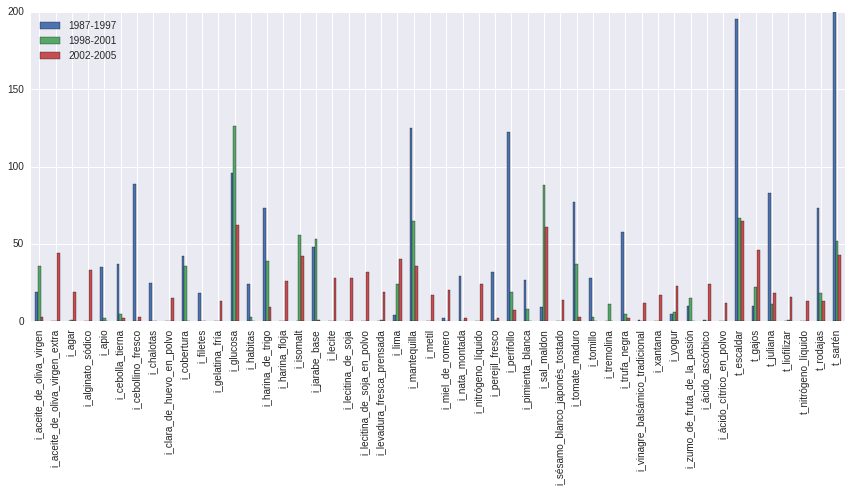

In [132]:
df.plot(kind='bar')

In [105]:
recipes_df[(1987 <= recipes_df['year']) & (recipes_df['year'] <= 1997)]

,_id,title,year,ingredients,techniques,creativity
0,1,terrina de melón con gelée de oporto,1987,"[aceite de oliva, agua, gelatina de oporto, ho...",[agua],10
1,10,salmonetes Gaudí,1987,"[aceite de oliva, anchoa en aceite, calabacín,...","[agua, brunoise, cocción, hervir, horno, marca...",10
2,100,oursins,1990,"[avellanas tostadas, azúcar, cacao en polvo, c...","[horno, secar]",10
13,101,diamantes,1990,"[azúcar, azúcar lustre, harina de trigo, huevo...",[rodajas],10
24,102,"coca de berenjena escalivada, bacon y costilli...",1991,"[aceite de oliva, aceite de oliva virgen, baco...","[horno, marcar, sal, sartén]",10
35,103,crudités de alcachofas y parmesano con costill...,1991,"[aceite de oliva, ajo, alcachofas, almendras, ...","[agua, cocción, horno, marinar, sal, sartén, t...",10
46,104,"mató con amapola, tomate, anchoas y aceite de ...",1991,"[aceite de girasol, aceite de oliva, albahaca ...","[agua, confitar, empanar, hervir, macerar, rod...",10
57,105,"coca de aguacate, anchoas y cebolla tierna al ...",1991,"[aceite de oliva virgen, aguacate, anchoas en ...","[agua, juliana, macerar]",10
68,106,virutas de aguacate con buey de mar,1991,"[agua, buey de mar, cebollino fresco, cilantro...","[agua, escaldar, hervir, rellenar, sal]",10
79,107,sardinitas al azafrán con coliflor y cebolla t...,1991,"[aceite de oliva, agua, azafrán, cebolla tiern...","[agua, macerar, rodajas, sal]",10


In [199]:
ig = nx.read_gexf('data/spanish_ingredients_lexicon_6.gexf')
tg = nx.read_gexf('data/spanish_techniques_lexicon_6.gexf')

In [200]:
ingrs = ig.nodes(data=True)
techs = tg.nodes(data=True)

In [201]:
ingrs[:2]

[('jugos de aceitunas verdes',
  {'count': 0, 'label': 'jugos de aceitunas verdes'}),
 ('levaduras saflageres s-23',
  {'count': 0, 'label': 'levaduras saflageres s-23'})]

In [202]:
top_ingrs = sorted(ingrs, key=lambda x: x[1]['count'], reverse=True)
top_techs = sorted(techs, key=lambda x: x[1]['count'], reverse=True)

In [203]:
top_ingrs[:20]

[('agua', {'count': 891, 'label': 'agua'}),
 ('sal', {'count': 624, 'label': 'sal'}),
 ('azúcar', {'count': 529, 'label': 'azúcar'}),
 ('aceite de oliva', {'count': 463, 'label': 'aceite de oliva'}),
 ('glucosa', {'count': 284, 'label': 'glucosa'}),
 ('aceite de girasol', {'count': 260, 'label': 'aceite de girasol'}),
 ('hoja de gelatina', {'count': 253, 'label': 'hoja de gelatina'}),
 ('nata líquida', {'count': 251, 'label': 'nata líquida'}),
 ('mantequilla', {'count': 226, 'label': 'mantequilla'}),
 ('pimienta negra', {'count': 168, 'label': 'pimienta negra'}),
 ('hojas de gelatina', {'count': 164, 'label': 'hojas de gelatina'}),
 ('sal maldon', {'count': 158, 'label': 'sal maldon'}),
 ('leche', {'count': 155, 'label': 'leche'}),
 ('perifollo', {'count': 148, 'label': 'perifollo'}),
 ('agar-agar en polvo', {'count': 143, 'label': 'agar-agar en polvo'}),
 ('cebolla', {'count': 135, 'label': 'cebolla'}),
 ('n|2o', {'count': 130, 'label': 'n|2o'}),
 ('fondant', {'count': 128, 'label': '

In [204]:
i_aux = top_ingrs[:21]
i_aux.remove(('hojas de gelatina', {'count': 164, 'label': 'hojas de gelatina'}))
i_aux

[('agua', {'count': 891, 'label': 'agua'}),
 ('sal', {'count': 624, 'label': 'sal'}),
 ('azúcar', {'count': 529, 'label': 'azúcar'}),
 ('aceite de oliva', {'count': 463, 'label': 'aceite de oliva'}),
 ('glucosa', {'count': 284, 'label': 'glucosa'}),
 ('aceite de girasol', {'count': 260, 'label': 'aceite de girasol'}),
 ('hoja de gelatina', {'count': 253, 'label': 'hoja de gelatina'}),
 ('nata líquida', {'count': 251, 'label': 'nata líquida'}),
 ('mantequilla', {'count': 226, 'label': 'mantequilla'}),
 ('pimienta negra', {'count': 168, 'label': 'pimienta negra'}),
 ('sal maldon', {'count': 158, 'label': 'sal maldon'}),
 ('leche', {'count': 155, 'label': 'leche'}),
 ('perifollo', {'count': 148, 'label': 'perifollo'}),
 ('agar-agar en polvo', {'count': 143, 'label': 'agar-agar en polvo'}),
 ('cebolla', {'count': 135, 'label': 'cebolla'}),
 ('n|2o', {'count': 130, 'label': 'n|2o'}),
 ('fondant', {'count': 128, 'label': 'fondant'}),
 ('zanahoria', {'count': 125, 'label': 'zanahoria'}),
 ('l

In [205]:
top_techs[:10]

[('agua', {'count': 891, 'label': 'agua'}),
 ('sal', {'count': 648, 'label': 'sal'}),
 ('min', {'count': 553, 'label': 'min'}),
 ('en agua', {'count': 435, 'label': 'en agua'}),
 ('hervir', {'count': 391, 'label': 'hervir'}),
 ('horno', {'count': 369, 'label': 'horno'}),
 ('hirviendo', {'count': 296, 'label': 'hirviendo'}),
 ('sartén', {'count': 295, 'label': 'sartén'}),
 ('puré', {'count': 245, 'label': 'puré'}),
 ('reducir', {'count': 230, 'label': 'reducir'})]

In [206]:
t_aux = top_techs[:14]
t_aux.remove(('agua', {'count': 891, 'label': 'agua'}))
t_aux.remove(('sal', {'count': 648, 'label': 'sal'}))
t_aux.remove(('min', {'count': 553, 'label': 'min'}))
t_aux.remove(('hirviendo', {'count': 296, 'label': 'hirviendo'}))
t_aux

[('en agua', {'count': 435, 'label': 'en agua'}),
 ('hervir', {'count': 391, 'label': 'hervir'}),
 ('horno', {'count': 369, 'label': 'horno'}),
 ('sartén', {'count': 295, 'label': 'sartén'}),
 ('puré', {'count': 245, 'label': 'puré'}),
 ('reducir', {'count': 230, 'label': 'reducir'}),
 ('jugo', {'count': 225, 'label': 'jugo'}),
 ('secar', {'count': 210, 'label': 'secar'}),
 ('escaldar', {'count': 203, 'label': 'escaldar'}),
 ('a fuego lento', {'count': 191, 'label': 'a fuego lento'})]

In [213]:
s1

aceite de girasol     260
aceite de oliva       463
agar-agar en polvo    143
agua                  891
azúcar                529
cebolla               135
fondant               128
glucosa               284
harina de trigo       121
hoja de gelatina      253
leche                 155
limón                 124
mantequilla           226
nata líquida          251
n|2o                  130
perifollo             148
pimienta negra        168
sal                   624
sal maldon            158
zanahoria             125
dtype: int64

In [207]:
i_d = dict((x[0], x[1]['count']) for x in i_aux)
t_d = dict((x[0], x[1]['count']) for x in t_aux)

In [208]:
s1 = pd.Series(i_d)
s2 = pd.Series(t_d)

/home/antonio/virtualenvs/elbulli/lib/python3.4/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


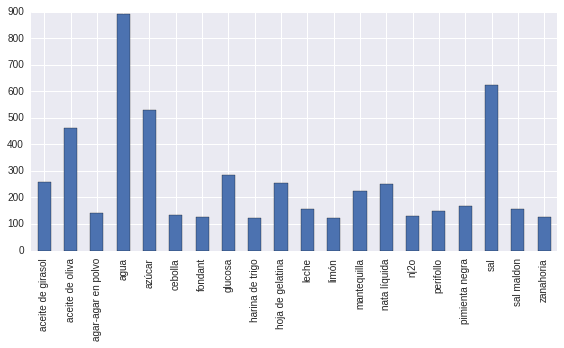

In [209]:
matplotlib.rcParams['figure.figsize'] = (8, 5)
s1.plot(kind='bar')

/home/antonio/virtualenvs/elbulli/lib/python3.4/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


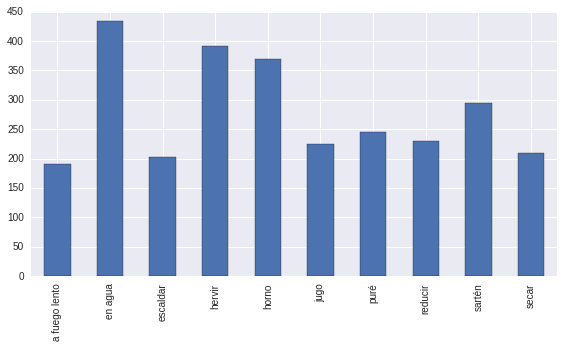

In [214]:
s2.plot(kind='bar')
matplotlib.rcParams['figure.figsize'] = (12, 7)